In [37]:
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import shapely
from shapely.geometry import mapping
# from shapely.geometry.polygon import Polygon
# from shapely.geometry.multipolygon import MultiPolygon
from explode import explode
from coord import coord
import matplotlib.pyplot as plt

In [38]:
#select country
n = 'ITA_w' 
#n = '2019_g25_100m_10-20_6m_02-01'
#n = '2019_g25_100m_10-20_1yr_02-01'
#n = '2018_g25_100m_10-20_6m_02-02'
#n = '2018_g25_100m_10-20_1yr_02-02'
#n = 'farm_pts_update'

#select sar folder
#f = '../Users/targets_0_sar/greece/'
f = '../targets_0_sar/'

#load sar predictions
pts = gpd.read_file(f + 'sar_' + n + '.geojson')
#pts = gpd.read_file(f + n + '.shp')

#load search area and exclusion zones
f2 = '/Users/Zack/0_seawarden/'
#search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_greece.shp')
#exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/GRC_exclusions_2020-01-07.geojson')
#farm_sites = gpd.read_file(f2 + 'greece/1_sites/farm_extent_286_edit.shp')

search_area = gpd.read_file(f2 + '0_search_areas/4_search_area/search_area_100m_' + n + '.shp')
exclusion_zones = gpd.read_file(f2 + '0_search_areas/7_exclusions/' + n + '_exclusions.geojson')

#re-project layers
crs = 'epsg:25830'
pts = pts.to_crs({'init': crs})
search_area = search_area.to_crs({'init': crs})
exclusion_zones = exclusion_zones.to_crs({'init': crs})


print('detections', len(pts), pts.crs)
print('search area', len(search_area), search_area.crs)
print('exclusion zones', len(exclusion_zones), exclusion_zones.crs)

detections 9528 {'init': 'epsg:25830'}
search area 1 {'init': 'epsg:25830'}
exclusion zones 12 {'init': 'epsg:25830'}


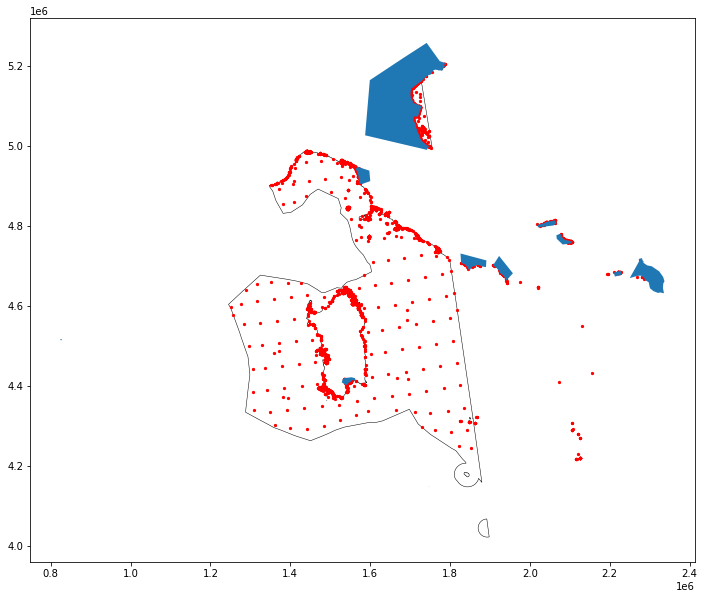

In [39]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
pts.plot(markersize=5, facecolor='red', ax=ax)
exclusion_zones.plot(ax=ax)

In [40]:
%%time 
#clip points to search area
clip = sjoin(pts, search_area, how='inner', op='within')
print('detections within search area:', len(clip))

detections within search area: 8078
Wall time: 2.05 s


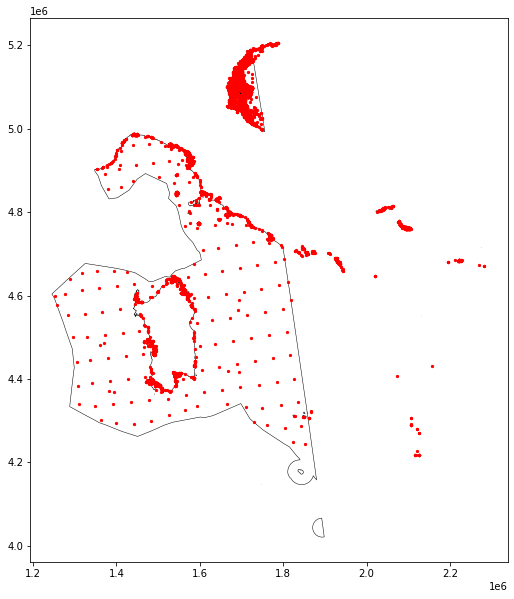

In [41]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
clip.plot(markersize=5, facecolor = 'red', ax=ax)

In [42]:
%%time 
#combine all exclusion zones
exclusion_zones['Dissolve'] = 0
exclusion_zones_dis = exclusion_zones.dissolve(by='Dissolve')

Wall time: 15.6 ms


In [43]:
%%time 
#exclude points in exclusion areas
mask = ~clip.within(exclusion_zones_dis.loc[0, 'geometry'])
clip2 = clip.loc[mask]
print('detections outside of exclusion zones:', len(clip2))

detections outside of exclusion zones: 1563
Wall time: 1.69 s


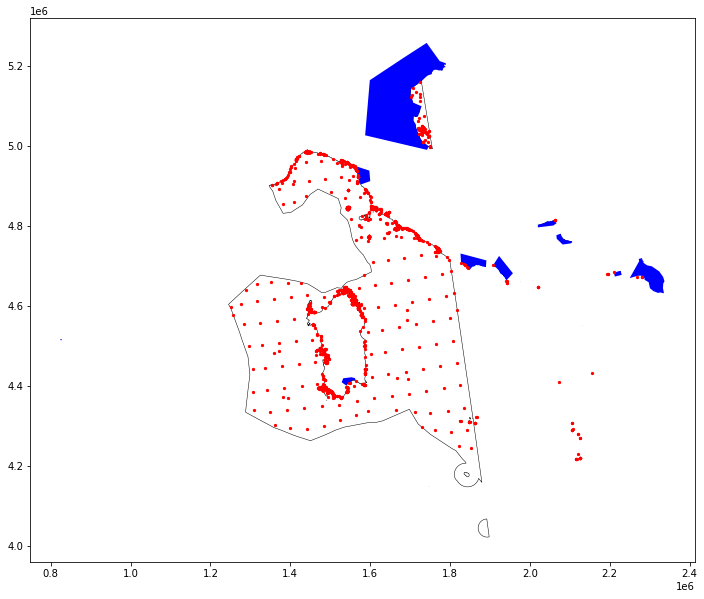

In [44]:
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
exclusion_zones_dis.plot(facecolor = 'blue', ax=ax)
clip2.plot(markersize=5, facecolor = 'red', ax=ax)

In [45]:
%%time 
#buffer points, dissolve buffers to aggregate points near each other
buffer = gpd.GeoDataFrame(geometry = clip2.buffer(10))
buffer['Dissolve'] = 0
buffer_dis = buffer.dissolve(by='Dissolve')

Wall time: 152 ms


In [46]:
%%time 
#explode polygon and generate centroids
buffer_exploded = explode(buffer_dis)      
centroids = gpd.GeoDataFrame(geometry = buffer_exploded.centroid)
#centroids = gpd.GeoDataFrame(geometry = pts.centroid)
print('detections after aggregation:', len(centroids))

detections after aggregation: 1556
Wall time: 572 ms


In [47]:
%%time 
#buffer centroids and make square polygons
centroid_buffer = gpd.GeoDataFrame(geometry = centroids.buffer(500))
envelope = gpd.GeoDataFrame(geometry = centroid_buffer.envelope)

Wall time: 107 ms


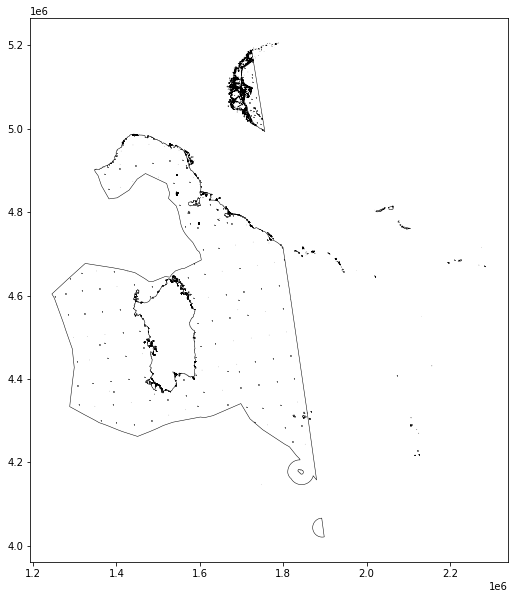

In [48]:
plt.rcParams['figure.figsize'] = (20, 10)
ax=search_area.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
centroid_buffer.plot(markersize=5, facecolor = 'black', ax=ax)
envelope.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

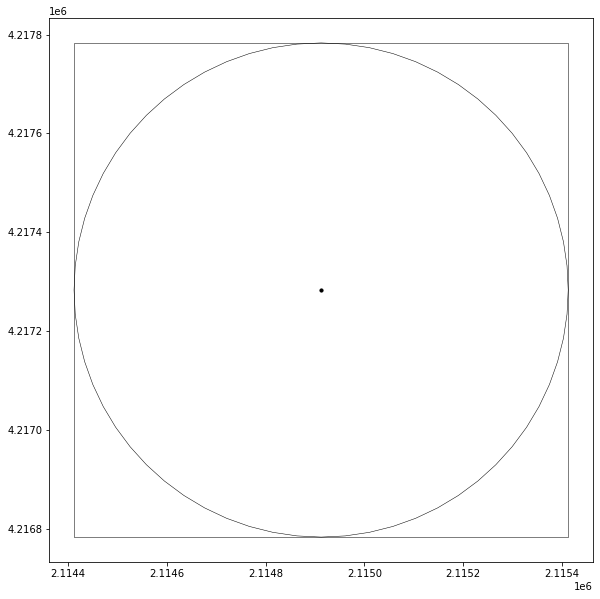

In [49]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = centroids.loc[[0], 'geometry'].plot(markersize=10, facecolor = 'black')
centroid_buffer.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)
envelope.loc[[0], 'geometry'].plot(linewidth=.5, edgecolor = 'black', facecolor = 'none', ax=ax)

In [50]:
#set crs
envelope.crs = {'init' : crs}
envelope['geometry'] = envelope['geometry'].to_crs(epsg=4326)
print(envelope.crs)
envelope.head()

{'init': 'epsg:25830'}


,geometry
0,"POLYGON ((14.99292782517083 36.70668484645382,..."
1,"POLYGON ((14.99421067001745 36.7067719691454, ..."
2,"POLYGON ((15.02132794187399 36.70398103461753,..."
3,"POLYGON ((15.00666187449241 36.70812204180243,..."
4,"POLYGON ((15.10457917127152 36.698020529328, 1..."


In [51]:
#extract lat/long for each square polygon (envelope)
coord_list = []
for i in range(len(envelope)):
    coords = mapping(envelope.geometry[i])['coordinates']
    coord_list.append(coords)

In [52]:
# #combine x/y point groups
coord_all = []
for i in range(len(coord_list)):
    coord_group = coord(coord_list[i]) #function to extract and format x/y points
    coord_group['id'] = i
    coord_all.append(coord_group) 
targets = pd.concat(coord_all)
print('total coordinates (5 per detection):', len(targets))
targets.head()

total coordinates (5 per detection): 7780


,x,y,id
0,14.992927825170831,36.70668484645382,0
1,15.003574449974751,36.7050197032671,0
2,15.005643435568977,36.71359191725715,0
3,14.994995752608473,36.71525757720375,0
4,14.992927825170831,36.70668484645382,0


In [53]:
#accuracy check
centroids_test = centroids.copy()
centroids_test.crs = {'init' :crs}
centroids_test['geometry'] = centroids_test['geometry'].to_crs(epsg=4326)

# matches = centroids_test.intersects(farm_sites.unary_union)
# count = centroids_test.loc[matches]

# detections_n = len(centroids_test)
# farm_n = len(farm_sites)
# matches_n = len(count)

# print('total detections:', len(pts))
# print('detections in search area:', detections_n)
# print('farm sites:', farm_n)
# print('matches:', matches_n)
# print('positive matches', round(matches_n / farm_n, 3))
# print('overall accuracy', round(matches_n / detections_n, 3))

# plt.rcParams['figure.figsize'] = (20, 10)
# ax=farm_sites.plot(linewidth=.5, edgecolor = 'black', facecolor = 'none')
# centroids_test.plot(markersize=1, facecolor = 'red', ax=ax)

In [54]:
pts.to_file(f2 + n + '.shp')
targets.to_csv(f2 + n + '.csv', index = None, header=True)

centroids_test.crs = {'init' :'epsg:4326'}
centroids_test.to_file(f2 + n + '_v2.shp')
centroids_test.to_file(f2 + n + '_v2.geojson', driver='GeoJSON')